In [5]:
# %pip install transformers
# %pip install spacy
# %pip install imblearn

# import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
# import spacy
# nlp = spacy.load('en_core_web_sm')

In [6]:
# Core
import re

#Data Manipulation 
import pandas as pd
import numpy as np

#Data Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# Preprocessing Tools
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


# NLP Tools
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

#Data Modeling
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier


#Data Evaluation 
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

# Ignore any warnings
import warnings;
warnings.filterwarnings('ignore')

In [7]:

col_names = [
        'id',               # Column 1: the ID of the statement ([ID].json).
        'label',            # Column 2: the label.
        'statement',        # Column 3: the statement.
        'subjects',         # Column 4: the subject(s).
        'speaker',          # Column 5: the speaker.
        'speaker_job_title', # Column 6: the speaker's job title.
        'state_info',       # Column 7: the state info.
        'party_affiliation', # Column 8: the party affiliation.
        
        'barely_true', # barely true counts.
        'false', # false counts.
        'half_true', # half true counts.
        'mostly_true', # mostly true counts.
        'pants_on_fire', # pants on fire counts.
        
        'context' # Column 14: the context (venue / location of the speech or statement).
    ]

def read_df(tsv_file: str) -> pd.DataFrame:
    df = pd.read_csv(tsv_file, delimiter='\t', dtype=object)
    # replaces all "null" or "NaN" values with an empty string
    df.fillna("", inplace=True)
    # labels the columns in the dataset using the data dictionary described in the README
    df.columns = col_names
    df = df.dropna(subset=["label", "statement"])
    df.drop(["id"], axis=1, inplace=True)
    return df

train_df = read_df('datasets/train.tsv')
test_df = read_df('datasets/test.tsv')
valid_df = read_df('datasets/valid.tsv')


In [8]:
pd.isna(train_df).sum()

pd.DataFrame({
    "train_na_count": pd.isna(train_df).sum(),
    "test_na_na_count": pd.isna(test_df).sum(),
    "valid_na_count": pd.isna(valid_df).sum(),
})


,train_na_count,test_na_na_count,valid_na_count
label,0,0,0
statement,0,0,0
subjects,0,0,0
speaker,0,0,0
speaker_job_title,0,0,0
state_info,0,0,0
party_affiliation,0,0,0
barely_true,0,0,0
false,0,0,0
half_true,0,0,0


### Labels

-  true – The statement is accurate and there’s nothing significant missing.
- mostly-true – The statement is accurate but needs clarification or additional information.
- half-true – The statement is partially accurate but leaves out important details or takes things out of context.
- barely-true – The statement contains an element of truth but ignores critical facts that would give a different impression.
- false – The statement is not accurate.
- pants-fire – The statement is not accurate and makes a ridiculous claim. a.k.a. "Liar, Liar, Pants on Fire!"


In [9]:
def label_frequency_plot(df, label, col_name):
    if col_name not in df:
        return
    fig, ax = plt.subplots(figsize=(10,6))
    df = train_df[ train_df["label"] == label ].copy()
    ax = sns.countplot(
        data=df, 
        x=col_name, order=df[col_name].value_counts()[:20].index,
        palette='pastel6')

    for p in ax.patches:
        annotation = ax.annotate(f'{round(p.get_height(), 2)}', (p.get_x() + p.get_width() / 2., p.get_height()/2.2), ha='center',
                    va='center', xytext=(0, 10), textcoords='offset points', rotation=90, fontsize=12
                    )

    ax.set_title(f'{label.title()} statements by {col_name.title()}', fontsize='x-large', pad=20)
    ax.set_xlabel(' ')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light', fontsize='small')
    ax.set_ylabel('Counts',fontsize='small');
        



def statement_frequency_plot(df, col_name):
    if col_name not in df:
        return
    fig, ax = plt.subplots(figsize=(10,6))
    ax = sns.countplot(
        data=train_df, 
        x=col_name, order=train_df[col_name].value_counts()[:20].index,
        palette='pastel6')

    for p in ax.patches:
        annotation = ax.annotate(f'{round(p.get_height(), 2)}', (p.get_x() + p.get_width() / 2., p.get_height()/2.2), ha='center',
                    va='center', xytext=(0, 10), textcoords='offset points', rotation=90, fontsize=12
                    )

    ax.set_title(f'Statements by {col_name.title()}', fontsize='x-large', pad=20)
    ax.set_xlabel(' ')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontweight='light', fontsize='small')
    ax.set_ylabel('Statements Counts',fontsize='small');
    


def label_dist_plot(df, title= "LIAR Dataset"):
    sns.set_theme(style="white", context="talk")

    label_frequencies = df['label'].value_counts(normalize=True)
    label_frequencies *= 100
    labels = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']
    label_frequencies = label_frequencies.reindex(index = labels)
    print(df['label'].value_counts())
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        plt.figure(figsize=(12, 6)) 
        axis = sns.barplot(label_frequencies, palette="coolwarm", width=.7, gap=.01)
        for p in axis.patches:
            axis.annotate(f'{round(p.get_height(), 2)}', (p.get_x() + p.get_width() / 2., p.get_height()/2.), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

        sns.despine(left=False, right=True, top=True, bottom=False);
        axis.set_title(f"Labels Distribution ({title.replace('-', ' ').title()}, {len(df):,} Samples)", size=20, pad=30);
        axis.set_xticklabels(axis.get_xticklabels(), rotation=45, ha='right');
        

In [10]:
num_unique_speakers = train_df['speaker'].nunique()
avg_statments = len(train_df) / num_unique_speakers

print(f"Unique speakers in dataset: {num_unique_speakers}")
print(f"Average statements made per speaker: {avg_statments}")

Unique speakers in dataset: 2910
Average statements made per speaker: 3.5185567010309278


In [11]:
###    SUBJECT    ###

def subject_dist_plot(df, subject):
    filtered_df = df[ df['subjects'] == subject ]
    filtered_df.reset_index(inplace=True)

    # calls the bar chart function we created earlier
    label_dist_plot(filtered_df, title=subject)
    
subject_df = train_df.copy()
def subject_bar_chart(df, subject):
    filtered_df = df[ df['subjects'] == subject ]
    filtered_df.reset_index(inplace=True)
def expand_subjects(df):
    
    df['subjects'] = df['subjects'].apply(lambda item: item.split(",") if isinstance(item, str) else item)
    df = df.explode('subjects')
    return df

subject_df = expand_subjects(train_df.copy())
num_unique_subjects = subject_df['subjects'].nunique()
print(f"Unique subjects in dataset: {num_unique_subjects}")



Unique subjects in dataset: 143


label
half-true      2114
false          1994
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: count, dtype: int64


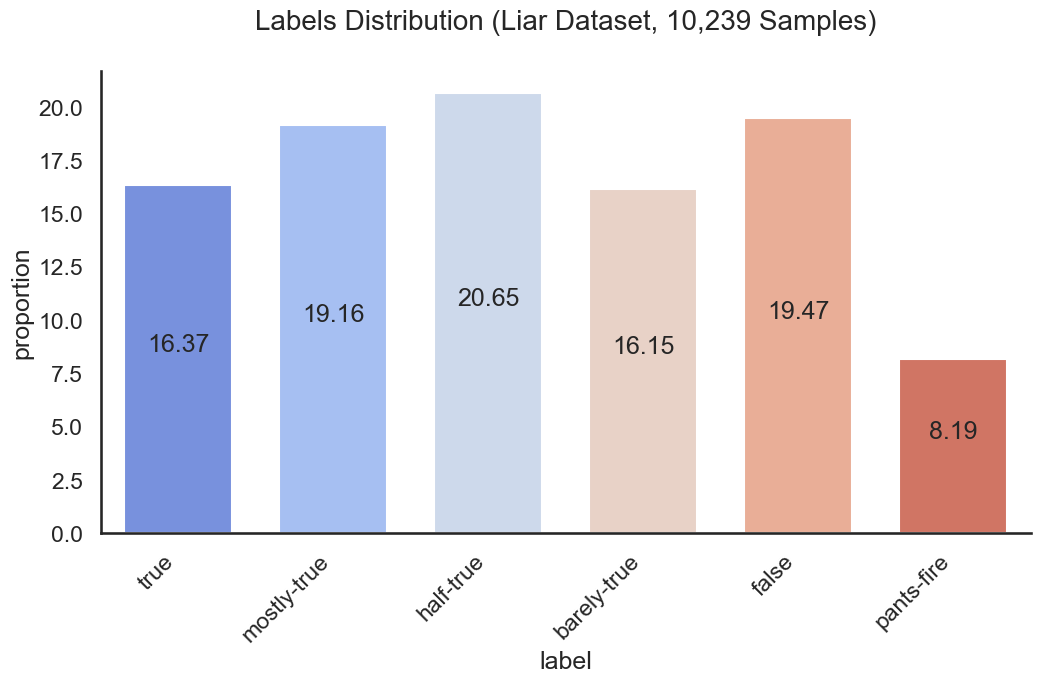

In [12]:
label_dist_plot(train_df)

label
mostly-true    25
half-true      22
barely-true    20
true           19
false          12
pants-fire     11
Name: count, dtype: int64


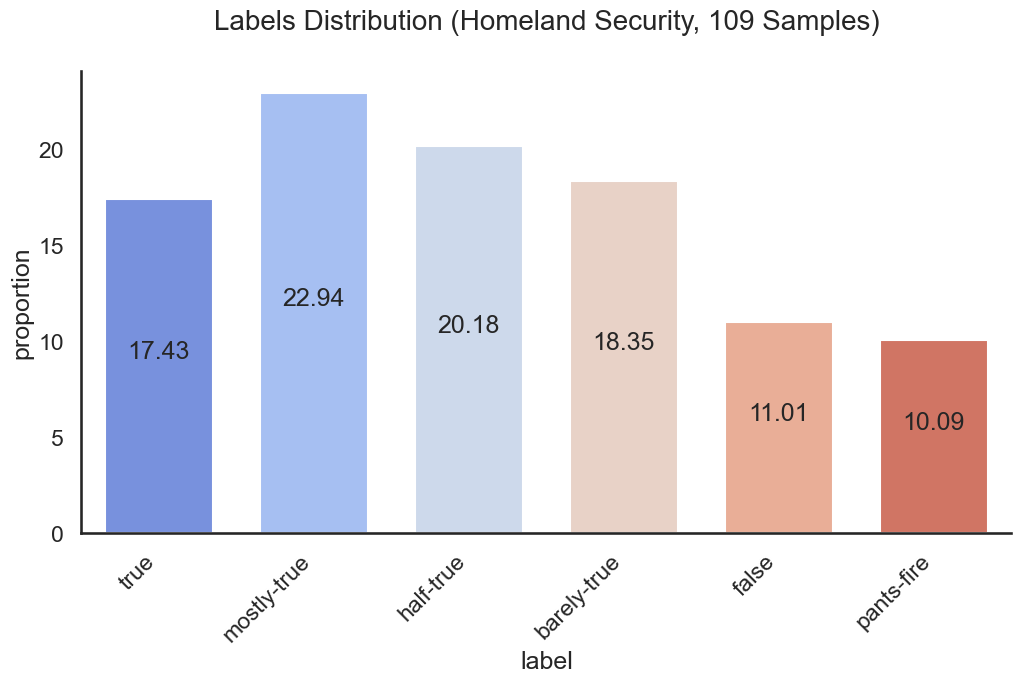

In [13]:
subject_dist_plot(subject_df, "homeland-security")

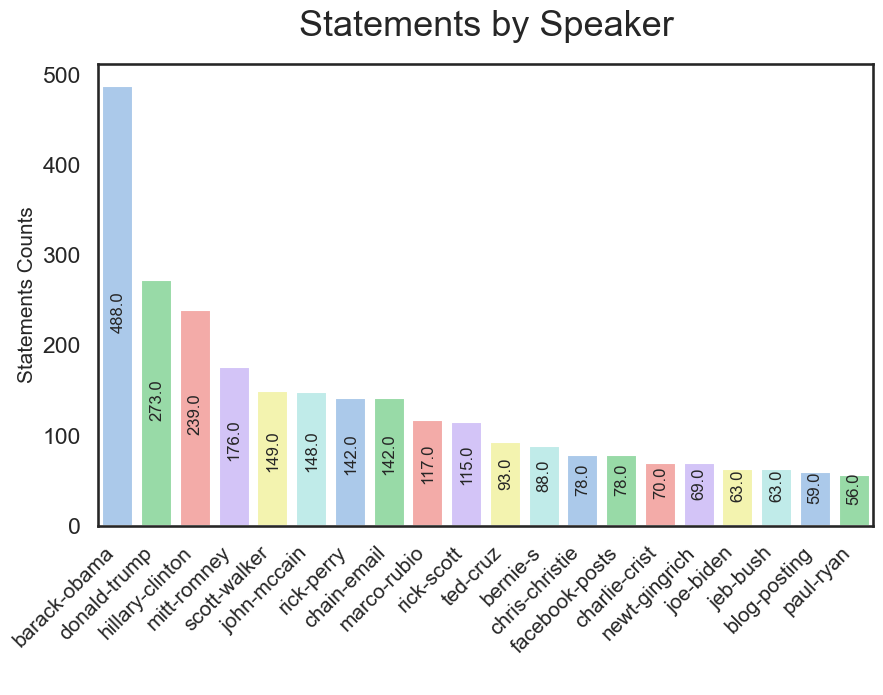

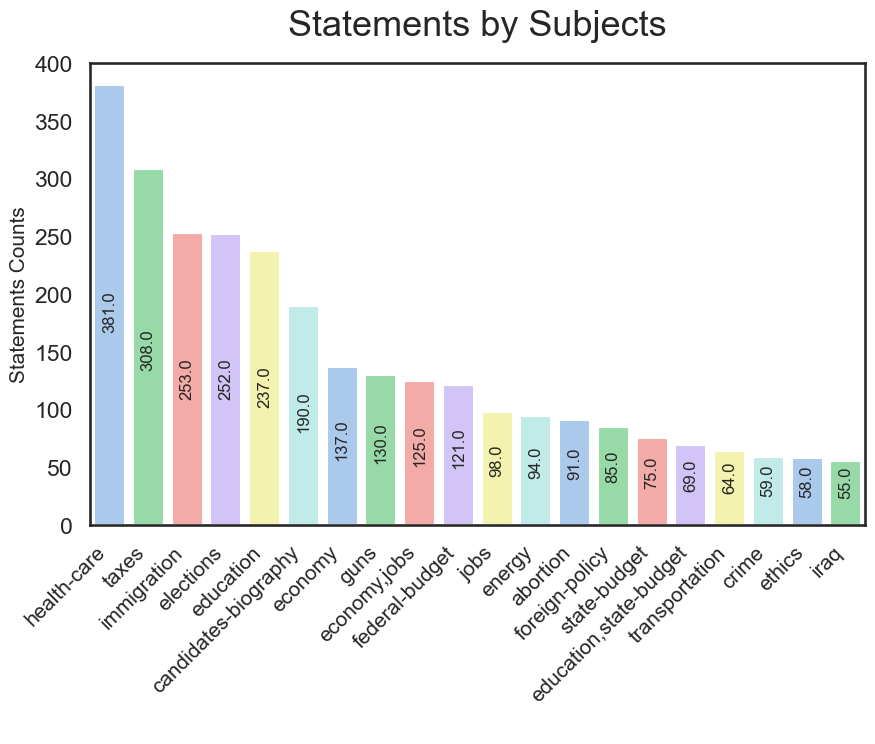

In [14]:
statement_frequency_plot(train_df, "speaker")
statement_frequency_plot(train_df, "subjects")

In [15]:
train_df["label"].unique()

array(['half-true', 'mostly-true', 'false', 'true', 'barely-true',
       'pants-fire'], dtype=object)

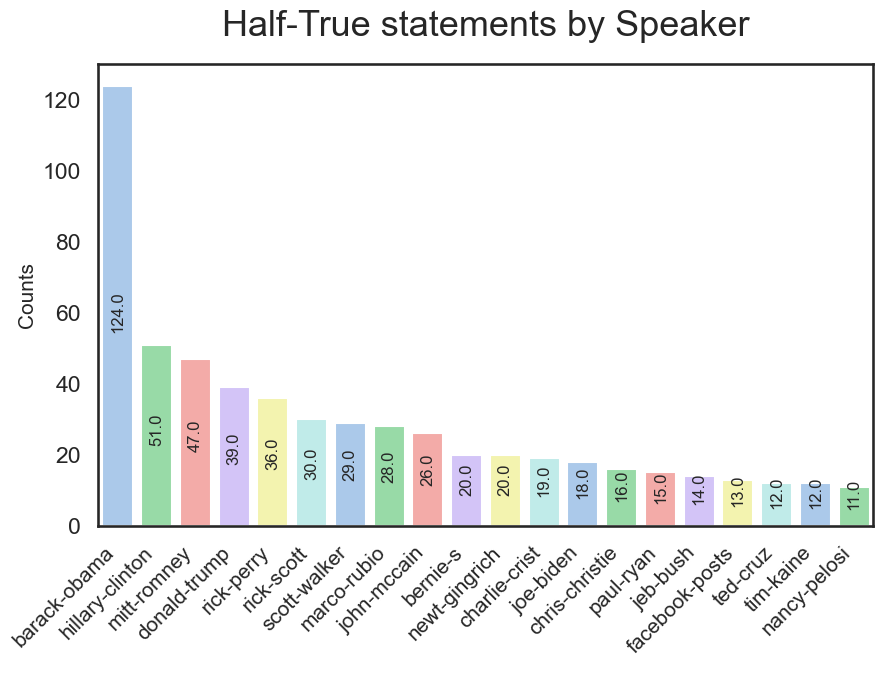

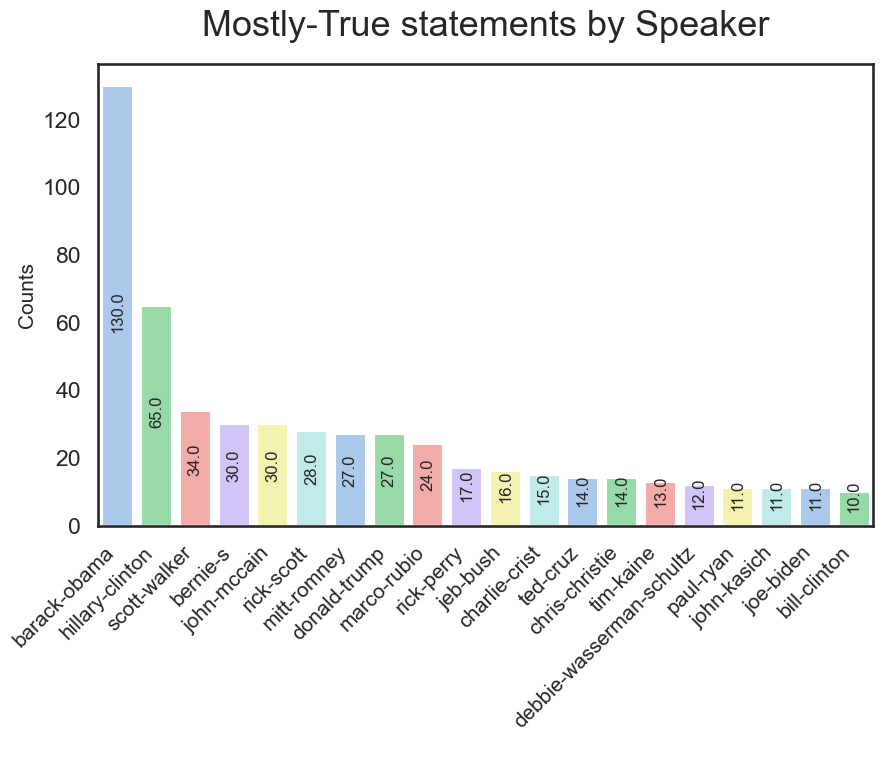

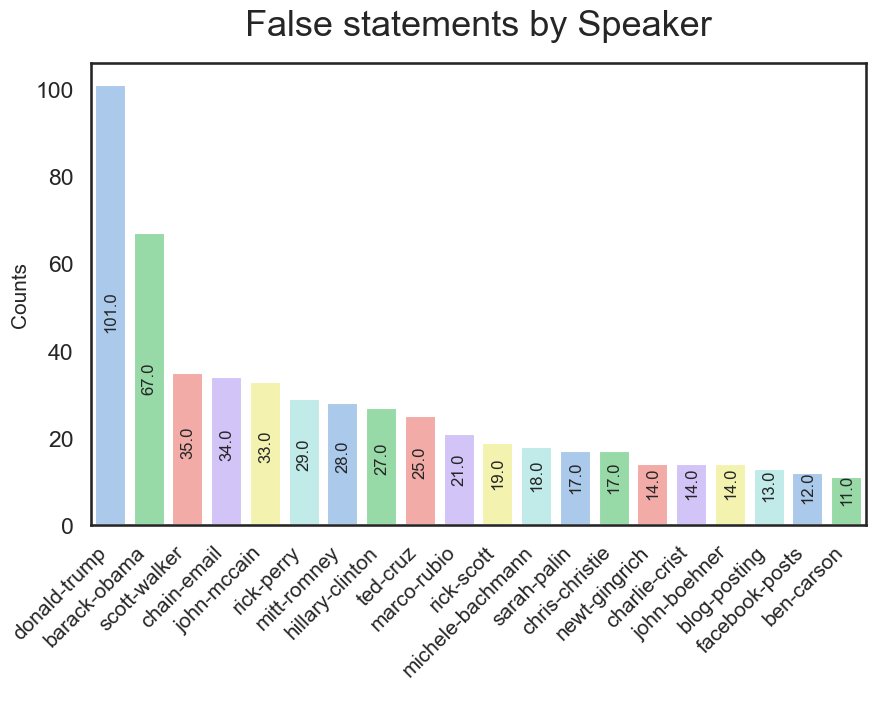

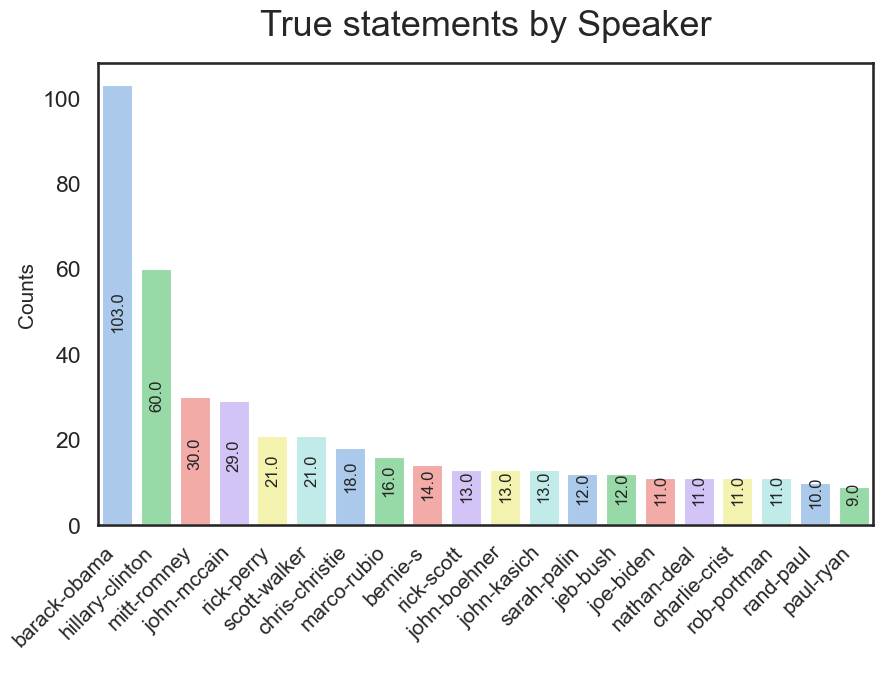

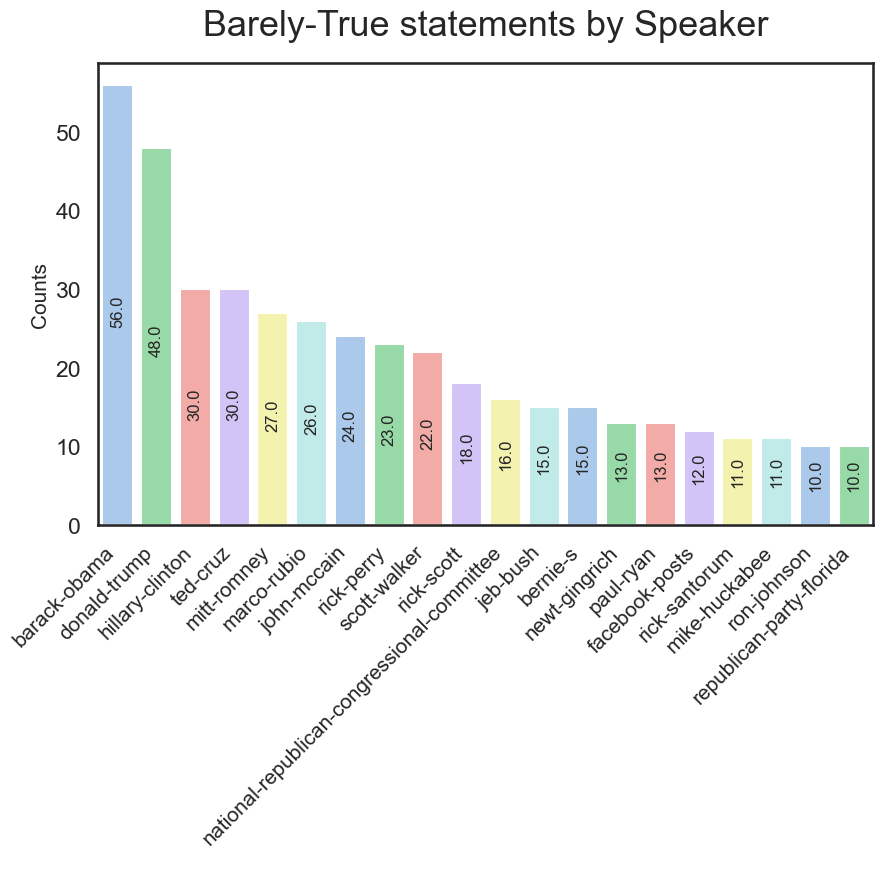

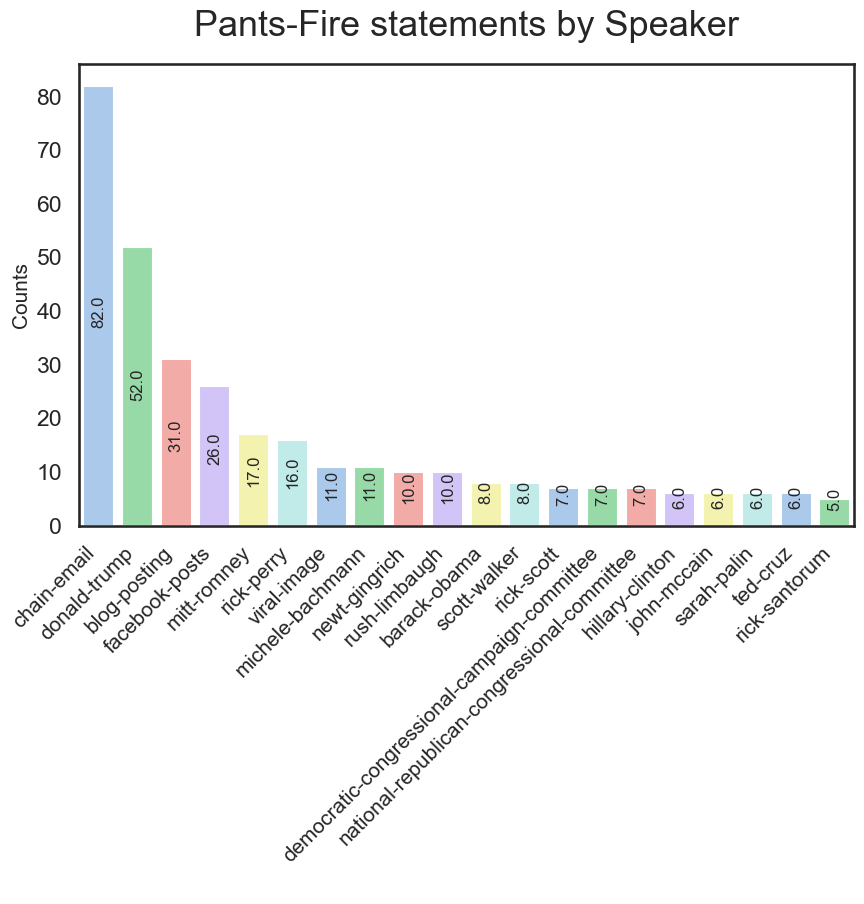

In [16]:
for label in train_df["label"].unique():
    label_frequency_plot(train_df, label, "speaker")


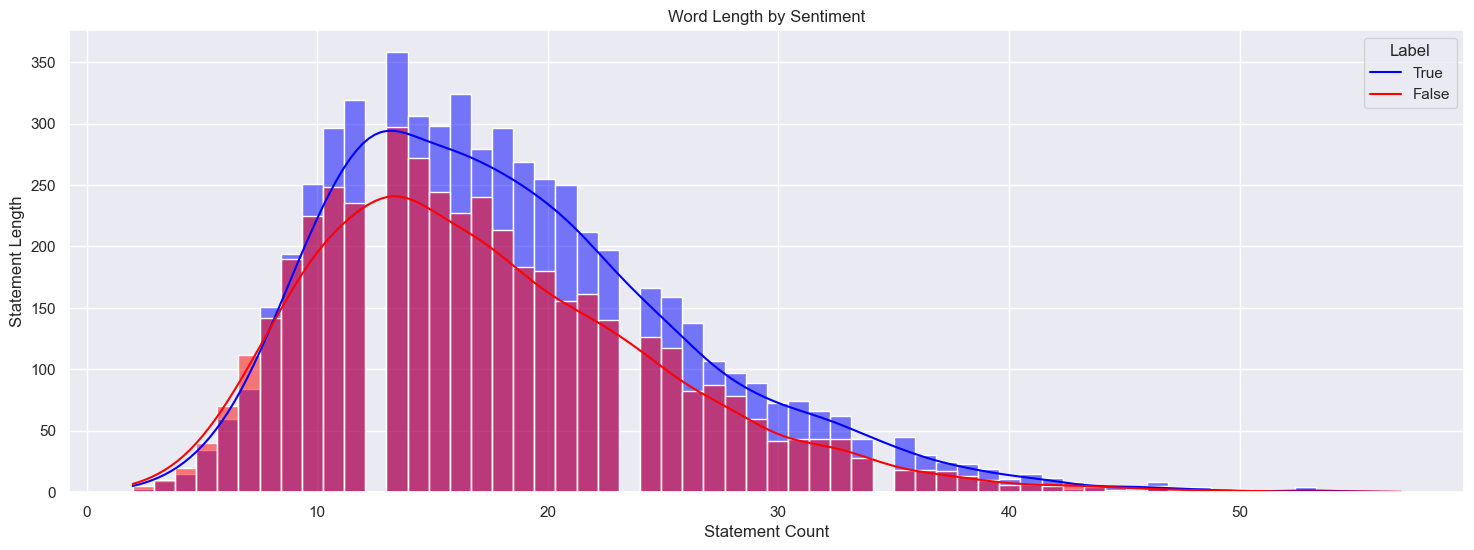

In [17]:
train_df['words'] = train_df['statement'].apply(lambda x: len(x.split() if type(x)==str else ' '))
train_df_copy = train_df.copy()
train_df_copy = train_df_copy[train_df_copy['words']<60]
train_df_copy['label'] = train_df_copy['label'].map(lambda l: 1 if l in ['half-true', 'mostly-true', 'true'] else 0)

sns.set()
fig, ax = plt.subplots(figsize=(18, 6))

custom_palette = sns.color_palette(['red', 'blue'], as_cmap=True)
sns.histplot(x='words', data=train_df_copy, bins='auto', kde=True, hue='label', legend=True, ax=ax, palette=custom_palette)
ax.set_title('Word Length by Sentiment')
ax.set_xlabel('Statement Count')
ax.set_ylabel('Statement Length')
ax.legend(['True', 'False'], title='Label')

plt.show()

In [18]:
from sklearn.preprocessing import LabelEncoder


label_encoder = LabelEncoder()
train_df['output'] = label_encoder.fit_transform(train_df["label"])
test_df['output'] = label_encoder.transform(test_df["label"])
valid_df['output'] = label_encoder.transform(valid_df["label"])

# train_df = expand_subjects(train_df)
# test_df = expand_subjects(test_df)
# valid_df = expand_subjects(valid_df)

train_df = train_df.map(lambda value: str(value).lower().replace('none', ''))
test_df = test_df.map(lambda value: str(value).lower().replace('none', ''))
valid_df = valid_df.map(lambda value: str(value).lower().replace('none', ''))

train_df.head(2)

,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,barely_true,false,half_true,mostly_true,pants_on_fire,context,words,output
0,half-true,when did the decline of coal start? it started...,"energy,history,job-accomplishments",scott-surovell,state delegate,virginia,democrat,0,0,1,1,0,a floor speech.,24,2
1,mostly-true,"hillary clinton agrees with john mccain ""by vo...",foreign-policy,barack-obama,president,illinois,democrat,70,71,160,163,9,denver,19,3


In [19]:

def reset_index(df):
    df = df.reset_index(drop=True)
    return df

def drop_na(df):
    df = df.dropna(subset=['input'], axis=0)
    return df

def drop_duplicated(df):
    df = df.drop_duplicates()
    return df


def label(df):
    df['output'] = df['label'].map({'true': 1,
                                     'mostly-true': 1,
                                     'half-true': 1,
                                     'false': 0,
                                     'barely-true': 0,
                                     'pants-fire': 0})
    return df


def clean_text(text):
    if not isinstance(text, str):
        return ''
    processed_text = text.lower()
    
    processed_text=re.sub(re.compile('[/(){}\[\]\|@,;]'),' ',processed_text)
    processed_text=re.sub(re.compile('[^0-9a-z #+_]'),' ',processed_text)
    
     # Tokenization
    words = word_tokenize(processed_text)
    
    # Lemmatize and stem each word
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stemmed_words = [lemmatizer.lemmatize(stemmer.stem(word)) for word in words]
    
    # Stop word removal
    stop_words = set(stopwords.words('english'))
    stop_words.update(['say', 'percent', 'state', 'year', 'said', 'people', 'one'])
    filtered_words = [word for word in stemmed_words if word.lower() not in stop_words]
    # Combine words
    processed_text = ' '.join(filtered_words)
    
    return processed_text

def clean_df(df):
    df['input'] = df['input'].apply(lambda x: clean_text(x))
    return df


In [20]:
cleaning_pipeline = Pipeline(steps=[
    ('drop_na', FunctionTransformer(drop_na)),
    ('drop_duplicated', FunctionTransformer(drop_duplicated)),
    ('label', FunctionTransformer(label)),
    ('clean', FunctionTransformer(clean_df)),
    ('reset_index', FunctionTransformer(reset_index))
])

In [21]:
# %pip install dill
# import dill

# with open("clean_text.pkl", "wb") as f:
#     dill.dump(clean_text, f)

In [22]:
x_features = ["statement", "subjects", "speaker", "context", "speaker_job_title", "state_info", 'barely_true', 'false', 'half_true', 'mostly_true', 'pants_on_fire']
y_feature = ["output"]


train_df["input"] = train_df[x_features].apply(lambda row: ' '.join(map(str, row)), axis=1)
test_df["input"] = test_df[x_features].apply(lambda row: ' '.join(map(str, row)), axis=1)
valid_df["input"] = valid_df[x_features].apply(lambda row: ' '.join(map(str, row)), axis=1)

train_df["output"] = train_df[y_feature].astype(int)
test_df["output"] = test_df[y_feature].astype(int)
valid_df["output"] = valid_df[y_feature].astype(int)

# Clean all datasets
train_df = cleaning_pipeline.fit_transform(train_df)
test_df = cleaning_pipeline.transform(test_df)
valid_df = cleaning_pipeline.transform(valid_df)

train_clean_df = train_df[["input", "output"]]
test_clean_df = test_df[["input", "output"]]
valid_clean_df = valid_df[["input", "output"]]


In [23]:
pd.set_option('display.max_colwidth', 500)
train_clean_df.head()


,input,output
0,declin coal start start natur ga took start begin presid georg w bush administr energi histori job accomplish scott surovel floor speech deleg virginia 0 0 1 1 0,1
1,hillari clinton agre john mccain vote give georg bush benefit doubt iran foreign polici barack obama denver presid illinoi 70 71 160 163 9,1
2,health care reform legisl like mandat free sex chang surgeri health care blog post news releas 7 19 3 5 44,0
3,econom turnaround start end term economi job charli crist interview cnn florida 15 9 20 19 2,1
4,chicago bear start quarterback last 10 total number tenur uw faculti fire dure last two decad educ robin vo onlin opinion piec wisconsin assembl speaker wisconsin 0 3 2 5 1,1


In [24]:
def print_cm_with_labels(y_true, y_pred):
    disp_labels = ['Fake', 'True']
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=disp_labels)

    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    ax.grid(False)
    disp.ax_.set_xticklabels(disp_labels)
    return None

Pipeline(steps=[('cv', CountVectorizer()), ('mnb', MultinomialNB())])
Training Accuracy: 0.7713
Validation Accuracy: 0.6165
Validation Precision: 0.6161


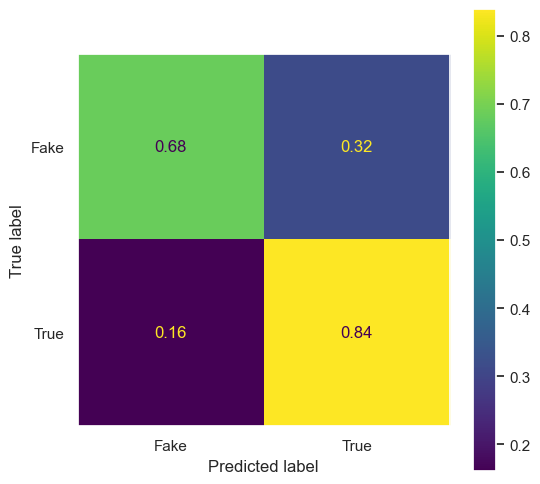

In [25]:
models_dict = {
    'mnb': MultinomialNB,
    'lr': LogisticRegression,
    'dtc': DecisionTreeClassifier,
    'rf': RandomForestClassifier,
    'etc': ExtraTreesClassifier,
    'gbc': GradientBoostingClassifier,
    'svc': SVC,
    'sgd': SGDClassifier,
    'pac': PassiveAggressiveClassifier,
    'mlp': MLPClassifier
}

# Dictionary mapping vectorizer names
vectorizers_dict = {
    'cv': CountVectorizer,
    'tfidf': TfidfVectorizer,
    'hash': HashingVectorizer,
}



def cross_validation_model(model_name, vectorizer_name, *, ros=False, params=None, params_rs=None, cm=False, ngram_range=(1,1)):
    X, y = train_clean_df["input"], train_clean_df["output"]
    X_val, y_val = valid_clean_df["input"], valid_clean_df["output"]
    model = models_dict.get(model_name, None)
    vectorizer = vectorizers_dict.get(vectorizer_name, None)
    if model is None or vectorizer is None:
        return None
    
    pipe = Pipeline([(vectorizer_name, vectorizer(ngram_range=ngram_range)),
               (model_name, model())])
    
    if ros:
        ros = RandomOverSampler()
        X, y = ros.fit_resample(np.array(X).reshape(-1, 1), y)
        X = pd.DataFrame(X).iloc[:,0]
    
    best_model = pipe
    if params is not None:
        grid_search = GridSearchCV(pipe, params, cv=5)
        best_model = grid_search
    elif params_rs is not None:
        grid_search = RandomizedSearchCV(pipe, params_rs, cv=5)
        best_model = grid_search
        
    best_model.fit(X, y) 
    if params or params_rs:
        print(best_model.best_params_)    
    
    print(pipe)
    y_pred = best_model.predict(X)
    acc = accuracy_score(y, y_pred)
    print(f'Training Accuracy: {round(acc, 4)}')
    y_pred_val = best_model.predict(X_val)
    acc_val = accuracy_score(y_val, y_pred_val)
    val_prec = precision_score(y_val, y_pred_val)
    print(f'Validation Accuracy: {round(acc_val, 4)}')        
    print(f'Validation Precision: {round(val_prec, 4)}')        
    if cm==True:
        print_cm_with_labels(y, best_model.predict(X))
    
    return best_model

cross_validation_model(model_name="mnb", vectorizer_name="cv", cm=True);


#### Naive Bayes

In [21]:
mnb_params_1 = [{'mnb__alpha':[.001, .01, .05, .1, .2, .4, .6, .8, 1, 2, 3, 4, 5, 6]}]
Mnb_1 = cross_validation_model("mnb", "cv", params=mnb_params_1);
print('-' * 80)
Mnb_2 = cross_validation_model('mnb', 'tfidf', params=mnb_params_1, ros=True, ngram_range=(1,3))


{'mnb__alpha': 4}
Pipeline(steps=[('cv', CountVectorizer()), ('mnb', MultinomialNB())])
Training Accuracy: 0.725
Validation Accuracy: 0.6212
Validation Precision: 0.6032
--------------------------------------------------------------------------------
{'mnb__alpha': 0.2}
Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('mnb', MultinomialNB())])
Training Accuracy: 0.9883
Validation Accuracy: 0.6399
Validation Precision: 0.6471


#### Logistic Regression

In [23]:
lr_params_1 = [{
    'lr__C':[0.001, 0.1, 1],
    'lr__solver':['lbfgs', 'saga', 'newton-cg', 'liblinear', 'sag'],
    'lr__fit_intercept':[True, False],
    'lr__penalty':['l1', 'l2', 'elasticnet', None],
    'lr__class_weight': ['balanced', None],
}]

lr_1 = cross_validation_model('lr', 'cv', params=lr_params_1)
print('-' * 80)
lr_params_2 = [{
    'lr__C':[0.1],
    'lr__solver':['saga'],
    'lr__fit_intercept':[False],
    'lr__penalty':['l2'],
    'lr__class_weight': [None],
}]
lr_2 = cross_validation_model('lr', 'tfidf', ros=True, params=lr_params_2)
print('-' * 80)


{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': True, 'lr__penalty': 'l2', 'lr__solver': 'sag'}
Pipeline(steps=[('cv', CountVectorizer()), ('lr', LogisticRegression())])
Training Accuracy: 0.7555
Validation Accuracy: 0.6282
Validation Precision: 0.6169
--------------------------------------------------------------------------------
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Pipeline(steps=[('tfidf', TfidfVectorizer()), ('lr', LogisticRegression())])
Training Accuracy: 0.6859
Validation Accuracy: 0.6251
Validation Precision: 0.6389
--------------------------------------------------------------------------------


In [24]:
lr_3 = cross_validation_model('lr', 'tfidf', ros=True, ngram_range=(1,2), params=lr_params_2)
print('-' * 80)


{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('lr', LogisticRegression())])
Training Accuracy: 0.7502
Validation Accuracy: 0.6345
Validation Precision: 0.6444
--------------------------------------------------------------------------------


In [25]:
lr_4 = cross_validation_model('lr', 'hash', ros=True, params=lr_params_2)
print('-' * 80)
lr_5 = cross_validation_model('lr', 'hash', ros=True, ngram_range=(1,2), params=lr_params_2)
print('-' * 80)
lr_6 = cross_validation_model('lr', 'hash', ros=True, ngram_range=(1,3), params=lr_params_2)
print('-' * 80)

{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Pipeline(steps=[('hash', HashingVectorizer()), ('lr', LogisticRegression())])
Training Accuracy: 0.6588
Validation Accuracy: 0.6228
Validation Precision: 0.6361
--------------------------------------------------------------------------------
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Pipeline(steps=[('hash', HashingVectorizer(ngram_range=(1, 2))),
                ('lr', LogisticRegression())])
Training Accuracy: 0.6882
Validation Accuracy: 0.6321
Validation Precision: 0.6437
--------------------------------------------------------------------------------
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Pipeline(steps=[('hash', HashingVectorizer(ngram_range=(1, 3))),
                ('lr', LogisticRegression())])
Training Accuracy: 0.7064
Validati

In [26]:
lr_4 = cross_validation_model('lr', 'hash', ros=True, params=lr_params_2)
print('-' * 80)
lr_5 = cross_validation_model('lr', 'hash', ros=True, ngram_range=(1,2), params=lr_params_2)
print('-' * 80)
lr_6 = cross_validation_model('lr', 'hash', ros=True, ngram_range=(1,3), params=lr_params_2)
print('-' * 80)

{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Pipeline(steps=[('hash', HashingVectorizer()), ('lr', LogisticRegression())])
Training Accuracy: 0.6634
Validation Accuracy: 0.6243
Validation Precision: 0.6372
--------------------------------------------------------------------------------
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Pipeline(steps=[('hash', HashingVectorizer(ngram_range=(1, 2))),
                ('lr', LogisticRegression())])
Training Accuracy: 0.6856
Validation Accuracy: 0.6274
Validation Precision: 0.6381
--------------------------------------------------------------------------------
{'lr__C': 0.1, 'lr__class_weight': None, 'lr__fit_intercept': False, 'lr__penalty': 'l2', 'lr__solver': 'saga'}
Pipeline(steps=[('hash', HashingVectorizer(ngram_range=(1, 3))),
                ('lr', LogisticRegression())])
Training Accuracy: 0.7063
Validati

#### Decision Tree Classifier

In [27]:
dtc_params_1 = [{
    'dtc__criterion':['gini', 'entropy'],
    'dtc__max_depth':[1, 2, 5, 8, 12, 16, 22],
    'dtc__ccp_alpha':[.001, .01, .1, .5],
    'dtc__splitter':['random', 'best'],
    'dtc__class_weight': ['balanced', None]
}]

dtc_1 = cross_validation_model('dtc', 'cv', params=dtc_params_1)
print('-' * 80)
dtc_params_2 = [{
    'dtc__criterion':['entropy'],
    'dtc__max_depth':[16],
    'dtc__ccp_alpha':[0],
    'dtc__splitter':['random'],
    'dtc__class_weight': [None]
}]
dtc_2 = cross_validation_model('dtc', 'tfidf', ros=True, params=dtc_params_2)
print('-' * 80)
dtc_3 = cross_validation_model('dtc', 'tfidf', ros=True, ngram_range=(1,2), params=dtc_params_2)
print('-' * 80)
dtc_4 = cross_validation_model('dtc', 'tfidf', ros=True, ngram_range=(1,3), params=dtc_params_2)
print('-' * 80)
dtc_5 = cross_validation_model('dtc', 'tfidf', ros=True, ngram_range=(2,3), params=dtc_params_2)
print('-' * 80)
dtc_6 = cross_validation_model('dtc', 'hash', ros=True, params=dtc_params_2)
print('-' * 80)
dtc_7 = cross_validation_model('dtc', 'hash', ros=True, ngram_range=(1,2), params=dtc_params_2)
print('-' * 80)
dtc_8 = cross_validation_model('dtc', 'hash', ros=True, ngram_range=(1,3), params=dtc_params_2)
print('-' * 80)
dtc_9 = cross_validation_model('dtc', 'hash', ros=True, ngram_range=(2,3), params=dtc_params_2)


{'dtc__ccp_alpha': 0.001, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 22, 'dtc__splitter': 'random'}
Pipeline(steps=[('cv', CountVectorizer()), ('dtc', DecisionTreeClassifier())])
Training Accuracy: 0.6178
Validation Accuracy: 0.597
Validation Precision: 0.5861
--------------------------------------------------------------------------------
{'dtc__ccp_alpha': 0, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('dtc', DecisionTreeClassifier())])
Training Accuracy: 0.6396
Validation Accuracy: 0.6064
Validation Precision: 0.5978
--------------------------------------------------------------------------------
{'dtc__ccp_alpha': 0, 'dtc__class_weight': None, 'dtc__criterion': 'entropy', 'dtc__max_depth': 16, 'dtc__splitter': 'random'}
Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('dtc', DecisionTreeClassifier(

#### Random Forest Classifier

In [30]:
rf_params_1 = [{
    'rf__criterion':['gini', 'entropy'],
    'rf__max_depth':[1, 2, 5, 8, 12, 16, 22],
    'rf__ccp_alpha':[.001, .01, .1, .5],
    'rf__n_estimators':[100, 500, 1000],
    'rf__class_weight': ['balanced', None],
    'rf__max_features': ['auto', 'sqrt', 'log2']
}]

rf_1 = cross_validation_model('rf', 'cv', params_rs=rf_params_1)
print('-' * 80)
rf_params_2 = [{
    'rf__criterion':['entropy'],
    'rf__max_depth':[22],
    'rf__ccp_alpha':[.001],
    'rf__n_estimators':[500],
    'rf__class_weight': ['balanced'],
    'rf__max_features': ['sqrt']
}]
rf_2 = cross_validation_model('rf', 'cv', ngram_range=(1,2), params=rf_params_2)
print('-' * 80)
rf_3 = cross_validation_model('rf', 'cv', ros=True, params=rf_params_2)
print('-' * 80)
rf_4 = cross_validation_model('rf', 'cv', ros=True, ngram_range=(1,2), params=rf_params_2)
print('-' * 80)
rf_5 = cross_validation_model('rf', 'tfidf', ngram_range=(1,2), params=rf_params_2)
print('-' * 80)
rf_6 = cross_validation_model('rf', 'tfidf', ros=True, params=rf_params_2)
print('-' * 80)
rf_7 = cross_validation_model('rf', 'tfidf', ros=True, ngram_range=(1,2), params=rf_params_2)
print('-' * 80)
rf_8 = cross_validation_model('rf', 'hash', ngram_range=(1,2), params=rf_params_2)

{'rf__n_estimators': 500, 'rf__max_features': 'sqrt', 'rf__max_depth': 8, 'rf__criterion': 'entropy', 'rf__class_weight': None, 'rf__ccp_alpha': 0.001}
Pipeline(steps=[('cv', CountVectorizer()), ('rf', RandomForestClassifier())])
Training Accuracy: 0.5861
Validation Accuracy: 0.5448
Validation Precision: 0.5344
--------------------------------------------------------------------------------
{'rf__ccp_alpha': 0.001, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 22, 'rf__max_features': 'sqrt', 'rf__n_estimators': 500}
Pipeline(steps=[('cv', CountVectorizer(ngram_range=(1, 2))),
                ('rf', RandomForestClassifier())])
Training Accuracy: 0.6837
Validation Accuracy: 0.6399
Validation Precision: 0.6209
--------------------------------------------------------------------------------
{'rf__ccp_alpha': 0.001, 'rf__class_weight': 'balanced', 'rf__criterion': 'entropy', 'rf__max_depth': 22, 'rf__max_features': 'sqrt', 'rf__n_estimators': 500}
Pipeline(ste

#### Extra Trees Classifier

In [31]:
etc_params_1 = [{
    'etc__criterion':['gini', 'entropy'],
    'etc__max_depth':[1, 2, 5, 8, 12, 16, 22],
    'etc__ccp_alpha':[0, .001, .01, .1, .5],
    'etc__n_estimators':[100, 500, 1000],
    'etc__class_weight': ['balanced', 'balanced_subsample', None],
    'etc__max_features': ['auto', 'sqrt', 'log2']
}]

etc_1 = cross_validation_model('etc', 'cv', params_rs=etc_params_1)
print('-' * 80)

etc_params_2 = [{
    'etc__criterion':['entropy'],
    'etc__max_depth':[16],
    'etc__ccp_alpha':[0],
    'etc__n_estimators':[500],
    'etc__class_weight': ['balanced'],
    'etc__max_features': ['sqrt']
}]
etc_2 = cross_validation_model('etc', 'cv', ngram_range=(2,2), params=etc_params_2)
print('-' * 80)
etc_3 = cross_validation_model('etc', 'tfidf', ngram_range=(2,2), params=etc_params_2)
print('-' * 80)
etc_4 = cross_validation_model('etc', 'cv', ngram_range=(1,2), params=etc_params_2)
print('-' * 80)
etc_6 = cross_validation_model('etc', 'cv', ros=True, ngram_range=(1,2), params=etc_params_2)
print('-' * 80)
etc_7 = cross_validation_model('etc', 'tfidf', ngram_range=(1,2), params=etc_params_2)
print('-' * 80)
etc_8 = cross_validation_model('etc', 'tfidf', ros=True, ngram_range=(1,2), params=etc_params_2)

{'etc__n_estimators': 1000, 'etc__max_features': 'log2', 'etc__max_depth': 5, 'etc__criterion': 'gini', 'etc__class_weight': None, 'etc__ccp_alpha': 0.5}
Pipeline(steps=[('cv', CountVectorizer()), ('etc', ExtraTreesClassifier())])
Training Accuracy: 0.5617
Validation Accuracy: 0.5207
Validation Precision: 0.5207
--------------------------------------------------------------------------------
{'etc__ccp_alpha': 0, 'etc__class_weight': 'balanced', 'etc__criterion': 'entropy', 'etc__max_depth': 16, 'etc__max_features': 'sqrt', 'etc__n_estimators': 500}
Pipeline(steps=[('cv', CountVectorizer(ngram_range=(2, 2))),
                ('etc', ExtraTreesClassifier())])
Training Accuracy: 0.7367
Validation Accuracy: 0.6095
Validation Precision: 0.5884
--------------------------------------------------------------------------------
{'etc__ccp_alpha': 0, 'etc__class_weight': 'balanced', 'etc__criterion': 'entropy', 'etc__max_depth': 16, 'etc__max_features': 'sqrt', 'etc__n_estimators': 500}
Pipeline

#### Gradient Boosting Classifier

In [32]:
gbc_params_1 = [{
    'gbc__learning_rate':[0.05, 0.1],
    'gbc__n_estimators':[40, 70]
}]

gbc_1 = cross_validation_model('gbc', 'cv', params=gbc_params_1)
print('-' * 80)

gbc_params_2 = [{
    'gbc__learning_rate':[0.05, 0.1],
    'gbc__n_estimators':[70, 100, 500]
}]

gbc_2 = cross_validation_model('gbc', 'cv', params=gbc_params_2)
print('-' * 80)

gbc_params_3 = [{
    'gbc__learning_rate':[0.005, 0.01],
    'gbc__n_estimators':[500, 1000]
}]

gbc_3 = cross_validation_model('gbc', 'cv', params=gbc_params_3)
print('-' * 80)

gbc_params_4 = [{
    'gbc__learning_rate':[0.001, 0.01],
    'gbc__n_estimators':[1000, 2000]
}]

gbc_4 = cross_validation_model('gbc', 'cv', params=gbc_params_4)
print('-' * 80)

gbc_params_5 = [{
    'gbc__learning_rate':[0.02, 0.01],
    'gbc__n_estimators':[3000, 2000]
}]

gbc_5 = cross_validation_model('gbc', 'cv', params=gbc_params_5)
print('-' * 80)

gbc_params_6 = [{
    'gbc__learning_rate':[0.02],
    'gbc__n_estimators':[2000],
    'gbc__loss':['deviance', 'exponential'],
    'gbc__max_features': ['sqrt', 'log2', None]
}]

gbc_6 = cross_validation_model('gbc', 'cv', params=gbc_params_6)

{'gbc__learning_rate': 0.1, 'gbc__n_estimators': 70}
Pipeline(steps=[('cv', CountVectorizer()),
                ('gbc', GradientBoostingClassifier())])
Training Accuracy: 0.6403
Validation Accuracy: 0.583
Validation Precision: 0.562
--------------------------------------------------------------------------------
{'gbc__learning_rate': 0.05, 'gbc__n_estimators': 500}
Pipeline(steps=[('cv', CountVectorizer()),
                ('gbc', GradientBoostingClassifier())])
Training Accuracy: 0.7026
Validation Accuracy: 0.6041
Validation Precision: 0.582
--------------------------------------------------------------------------------
{'gbc__learning_rate': 0.01, 'gbc__n_estimators': 1000}
Pipeline(steps=[('cv', CountVectorizer()),
                ('gbc', GradientBoostingClassifier())])
Training Accuracy: 0.6572
Validation Accuracy: 0.5869
Validation Precision: 0.5667
--------------------------------------------------------------------------------
{'gbc__learning_rate': 0.01, 'gbc__n_estimators': 

#### C-Support Vector Classification

In [33]:
svc_params_1 = [{
    'svc__C':[0.5, 1, 1.5],
    'svc__shrinking':[True, False]
}]

svc_1 = cross_validation_model('svc', 'cv', params_rs=svc_params_1)
print('-' * 80)

svc_params_2 = [{
    'svc__C':[1],
    'svc__gamma':['scale', 'auto'],
    'svc__tol':[0.001, 0.0001],
    'svc__shrinking':[True]
}]

svc_2 = cross_validation_model('svc', 'cv', params_rs=svc_params_2)
print('-' * 80)

svc_params_3 = [{
    'svc__C':[1],
    'svc__gamma':['scale'],
    'svc__tol':[0.01, 0.001],
    'svc__shrinking':[True],
    'svc__class_weight': ['balanced', None]
}]

svc_3 = cross_validation_model('svc', 'cv', params_rs=svc_params_3)
print('-' * 80)

svc_params_4 = [{
    'svc__C':[1],
    'svc__gamma':['scale'],
    'svc__tol':[0.001,],
    'svc__shrinking':[True],
    'svc__class_weight': [None]
}]

svc_4 = cross_validation_model('svc', 'cv', ros=True, params=svc_params_4)
print('-' * 80)
svc_5 = cross_validation_model('svc', 'cv', ros=True, ngram_range=(1,2), params=svc_params_4)
print('-' * 80)
svc_6 = cross_validation_model('svc', 'cv', ros=True, ngram_range=(2,2), params=svc_params_4)
print('-' * 80)
svc_7 = cross_validation_model('svc', 'tfidf', ros=True, ngram_range=(2,2), params=svc_params_4)
print('-' * 80)
svc_8 = cross_validation_model('svc', 'tfidf', ros=True, ngram_range=(2,2), params=svc_params_4)
print('-' * 80)
svc_9 = cross_validation_model('svc', 'hash', ngram_range=(2,2), params=svc_params_4)
print('-' * 80)
svc_10 = cross_validation_model('svc', 'hash', ros=True, ngram_range=(2,2), params=svc_params_4)

{'svc__shrinking': True, 'svc__C': 1}
Pipeline(steps=[('cv', CountVectorizer()), ('svc', SVC())])
Training Accuracy: 0.9051
Validation Accuracy: 0.6352
Validation Precision: 0.6144
--------------------------------------------------------------------------------
{'svc__tol': 0.001, 'svc__shrinking': True, 'svc__gamma': 'scale', 'svc__C': 1}
Pipeline(steps=[('cv', CountVectorizer()), ('svc', SVC())])
Training Accuracy: 0.9051
Validation Accuracy: 0.6352
Validation Precision: 0.6144
--------------------------------------------------------------------------------
{'svc__tol': 0.001, 'svc__shrinking': True, 'svc__gamma': 'scale', 'svc__class_weight': None, 'svc__C': 1}
Pipeline(steps=[('cv', CountVectorizer()), ('svc', SVC())])
Training Accuracy: 0.9051
Validation Accuracy: 0.6352
Validation Precision: 0.6144
--------------------------------------------------------------------------------
{'svc__C': 1, 'svc__class_weight': None, 'svc__gamma': 'scale', 'svc__shrinking': True, 'svc__tol': 0.0

#### Stochastic Gradient Descent Classifier

In [39]:
sgd_params_1 = [{
    'sgd__loss':['hinge', 'log_loss'],
    'sgd__alpha':[0.01, 0.001, 0.0001],
    'sgd__early_stopping': [True]
}]

sgd_1 = cross_validation_model('sgd', 'cv', params=sgd_params_1)
print('-' * 80)

sgd_params_2 = [{
    'sgd__loss':['log_loss'],
    'sgd__penalty':['l1', 'l2'],
    'sgd__alpha':[0.1, 0.01],
    'sgd__early_stopping': [True]
}]

sgd_2 = cross_validation_model('sgd', 'cv', params=sgd_params_2)
print('-' * 80)

sgd_params_3 = [{
    'sgd__loss':['log_loss'],
    'sgd__penalty':['l2'],
    'sgd__alpha':[0.01],
    'sgd__fit_intercept':[True, False],
    'sgd__learning_rate': ['optimal', 'constant', 'invscaling', 'adaptive'],
    'sgd__early_stopping': [True]
}]

sgd_3 = cross_validation_model('sgd', 'cv', params=sgd_params_3)
print('-' * 80)

sgd_params_4 = [{
    'sgd__loss':['log_loss'],
    'sgd__penalty':['l2'],
    'sgd__alpha':[0.01],
    'sgd__fit_intercept':[False],
    'sgd__learning_rate': ['optimal'],
    'sgd__early_stopping': [True]
}]

sgd_4 = cross_validation_model('sgd', 'cv', params=sgd_params_4)
print('-' * 80)
sgd_5 = cross_validation_model('sgd', 'tfidf', params=sgd_params_4)
print('-' * 80)
sgd_6 = cross_validation_model('sgd', 'hash', params=sgd_params_4)
print('-' * 80)
sgd_7 = cross_validation_model('sgd', 'tfidf', ros=True, params=sgd_params_4)
print('-' * 80)
sgd_8 = cross_validation_model('sgd', 'cv', ros=True, params=sgd_params_4)
print('-' * 80)
sgd_9 = cross_validation_model('sgd', 'tfidf', ngram_range=(1,2), params=sgd_params_4)
print('-' * 80)
sgd_10 = cross_validation_model('sgd', 'cv', ngram_range=(1,2), params=sgd_params_4)

{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__loss': 'hinge'}
Pipeline(steps=[('cv', CountVectorizer()), ('sgd', SGDClassifier())])
Training Accuracy: 0.6786
Validation Accuracy: 0.622
Validation Precision: 0.596
--------------------------------------------------------------------------------
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__loss': 'log_loss', 'sgd__penalty': 'l2'}
Pipeline(steps=[('cv', CountVectorizer()), ('sgd', SGDClassifier())])
Training Accuracy: 0.6767
Validation Accuracy: 0.622
Validation Precision: 0.6009
--------------------------------------------------------------------------------
{'sgd__alpha': 0.01, 'sgd__early_stopping': True, 'sgd__fit_intercept': False, 'sgd__learning_rate': 'optimal', 'sgd__loss': 'log_loss', 'sgd__penalty': 'l2'}
Pipeline(steps=[('cv', CountVectorizer()), ('sgd', SGDClassifier())])
Training Accuracy: 0.6767
Validation Accuracy: 0.636
Validation Precision: 0.6108
-------------------------------------------------------

#### Passive Aggressive Classifier

In [35]:
pac_params_1 = [{
    'pac__C':[0.5, 1.0, 1.5, 2.0],
    'pac__fit_intercept':[True,False]
}]

pac_1 = cross_validation_model('pac', 'cv', params=pac_params_1)
print('-' * 80)

pac_params_2 = [{
    'pac__C':[1.5],
    'pac__fit_intercept':[True],
    'pac__class_weight': ['balanced', None],
    'pac__average': [True, False, 5, 10]
}]

pac_2 = cross_validation_model('pac', 'cv', params=pac_params_2)

{'pac__C': 1.5, 'pac__fit_intercept': False}
Pipeline(steps=[('cv', CountVectorizer()),
                ('pac', PassiveAggressiveClassifier())])
Training Accuracy: 0.9409
Validation Accuracy: 0.5729
Validation Precision: 0.5822
--------------------------------------------------------------------------------
{'pac__C': 1.5, 'pac__average': True, 'pac__class_weight': None, 'pac__fit_intercept': True}
Pipeline(steps=[('cv', CountVectorizer()),
                ('pac', PassiveAggressiveClassifier())])
Training Accuracy: 0.9434
Validation Accuracy: 0.5924
Validation Precision: 0.6049


# Best Model

In [52]:
import tensorflow

tensorflow.__version__

'2.15.0'

In [26]:
mnb_params_1 = [{'mnb__alpha':[.2]}]
print('-' * 80)
Mnb_2 = cross_validation_model('mnb', 'tfidf', params=mnb_params_1, ros=True, ngram_range=(1,3))


--------------------------------------------------------------------------------
{'mnb__alpha': 0.2}
Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('mnb', MultinomialNB())])
Training Accuracy: 0.9897
Validation Accuracy: 0.6352
Validation Precision: 0.6412


In [27]:
Mnb_2.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 3))),
                ('mnb', MultinomialNB(alpha=0.2))])

In [28]:
Mnb_2.estimator[0]
import joblib

joblib.dump(Mnb_2.best_estimator_, "estimator.joblib", compress = 1)


['estimator.joblib']

In [4]:
import joblib

loaded_vectorizer = joblib.load("vectorizer.joblib")
loaded_classifier = joblib.load("classifier.joblib")

loaded_vectorizer.transform(["asdada"])

NotFittedError: The TF-IDF vectorizer is not fitted